In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
import numpy as np
from typing import List
import torch.nn as nn
import torch
from sklearn.tree import BaseDecisionTree
from functools import partial

def shift_bit_eps(bit: int, eps: float = 0.5):
    assert bit in [0,1], "Bit must be 0 or 1"
    return (2 * eps - 1) * bit + 1 - eps

def create_base_vectors(circuit: List[int], eps: float = 0.5):
    vectors = []
    n = len(circuit)
    
    for i in range(n):
        vector = list(circuit).copy()
        vector[i] = shift_bit_eps(vector[i], eps=eps)
        vectors.append(vector)
        
    return vectors

def create_linear_system(vectors: List[List[float]]):
    X = np.array(vectors)

    y = -X[:,-1]

    X[:,-1] = 1
    
    return X,y

class BitComparison(nn.Module):
    def __init__(self,target: List[int], eps : float = 0.5):
        super(BitComparison, self).__init__()
                
        vectors = create_base_vectors(target, eps=eps)
        X,y = create_linear_system(vectors)
        W = np.linalg.solve(X,y)
        w = W[:-1]
        w = np.concatenate([w,np.ones(1)])
        c = W[-1]
        
        if not target[-1]:
            w = -w
            c = -c
            
        n = len(target)
        self.n = n
        self.linear = nn.Linear(n,1)
        
        self.linear.weight.data = torch.tensor(w.reshape(1,-1)).float()
        self.linear.bias.data = torch.tensor(c).unsqueeze(0).float()
        
    def forward(self,x):
        return self.linear(x)
        
    def __repr__(self):
        output = ""
        for i in range(self.n):
            if i < self.n - 1:
                output += f"{self.linear.weight.data[0][i]}*x_{i} + "
            else:
                output += f"{self.linear.weight.data[0][i]}*y + "
        output += f"{self.linear.bias.data[0]} = 0"
        return output

In [ ]:

import itertools

def create_test_cases_x(n):
    products = [[0,1]] * n

    x = list(itertools.product(*products))
    x = np.array(x)
    
    return x

def create_test_cases_y(x,target):
    y = ((x == target).sum(axis=1) == n).astype(int)
    return y

In [ ]:
eps = 0.25
n = 7

x = create_test_cases_x(n)

for target in x:
    y = create_test_cases_y(x,target)
    y = torch.tensor(y)
    
    bitcomparison = BitComparison(target, eps=eps)
    accuracy = (y == (bitcomparison.linear(torch.tensor(x).float()) > 0).view(-1)).float().mean().item()
    
    assert accuracy == 1, f"Accuracy inferior to 1 {accuracy}"

In [ ]:
print(bitcomparison)

1.0*x_0 + 1.0*x_1 + 1.0*x_2 + 1.0*x_3 + 1.0*x_4 + 1.0*x_5 + 1.0*y + -6.25 = 0


In [ ]:
fig = plt.figure()
fig.show()

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 432x288 with 0 Axes>

In [ ]:
# export
def plot_graph_function_approximation(f, dilatation_factor=50, polynomial_degree=25, bound=1, convertToTensor=True):
    if convertToTensor:
        f_a = lambda x: f(torch.tensor(x*a))
    else:
        f_a = lambda x: f(x*a)
        
    domain = [-A,A]

    p = Chebyshev.interpolate(f_a,deg=n,domain=domain)

    x = np.linspace(*domain,100)
    y = f_a(x)
    pred = p(x)

    y2 = tanh_a(x)
    pred2 = p_tanh(x)

    fig, ax = plt.subplots()

    # plot the function
    ax.plot(x,y1, 'g', label="Sigmoid")
    ax.plot(x,pred1,"b-", label=f"Polynomial approximation")
    ax.legend()

    # show the plot
    fig.suptitle(f"Tchebytchev polynomials with expansion a={a} and degree n={n}")
    fig.show()
    
    return fig,ax

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aa6f4e28c8>)

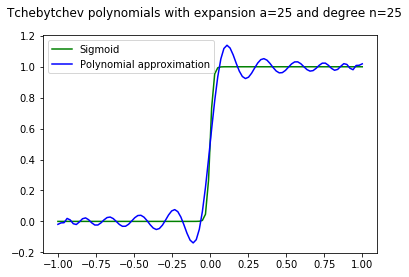

In [ ]:
plot_graph_function_approximation(torch.sigmoid)

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


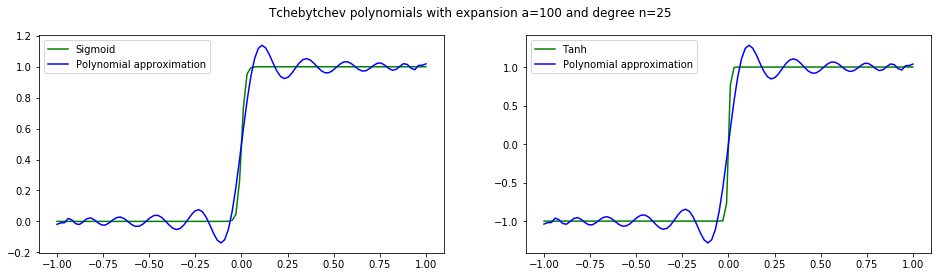

In [ ]:
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt

a = 100
n = 25
A = 1
domain = [-A,A]

sigmoid_a = lambda x: torch.sigmoid(torch.tensor(x*a))
p_sigmoid = Chebyshev.interpolate(sigmoid_a,deg=n,domain=domain)

tanh_a = lambda x: torch.tanh(torch.tensor(x*a))
p_tanh = Chebyshev.interpolate(tanh_a, deg=n, domain=domain)

x = np.linspace(*domain,100)
y1 = sigmoid_a(x)
pred1 = p_sigmoid(x)

y2 = tanh_a(x)
pred2 = p_tanh(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# plot the function
ax1.plot(x,y1, 'g', label="Sigmoid")
ax1.plot(x,pred1,"b-", label=f"Polynomial approximation")
ax1.legend()

# plot the function
ax2.plot(x,y2, 'g', label="Tanh")
ax2.plot(x,pred2,"b-", label=f"Polynomial approximation")
ax2.legend()

# show the plot
fig.suptitle(f"Tchebytchev polynomials with expansion a={a} and degree n={n}")
fig.show()

In [ ]:
eps = 0.005

x = torch.linspace(-eps,eps,)
delta_x = x[1] - x[0]

l_sigmoid = torch.norm(p_sigmoid(x) - sigmoid_a(x))
l_tanh = torch.norm(p_tanh(x) - tanh_a(x))

print(f"Loss of sigmoid : {l_sigmoid}")
print(f"Loss of tanh : {l_tanh}")

a,b = len(x) // 2 - len(x) // 4, len(x) // 2 + len(x) // 4

def derivative(f,x,i,delta_x):
    output = (f(x[i+1]) - f(x[i])) / delta_x
    return output

derivatives_tanh = []
derivatives_sigmoid = []

for i in range(a,b):
    derivatives_sigmoid.append(derivative(p_sigmoid,x,i,delta_x))
    derivatives_tanh.append(derivative(p_tanh,x,i,delta_x))
    
print(f"Mean derivative of sigmoid : {torch.tensor(derivatives_sigmoid).mean()}")
print(f"Mean derivative of tanh : {torch.tensor(derivatives_tanh).mean()}")

saturation = 0.9
precision = 1e-3

i = 0
while p_sigmoid(i * precision) <= saturation:
    i += 1
print(f"Saturation point of {saturation} for sigmoid : {i} * {precision}")

i = 0
while p_tanh(i * precision) <= saturation:
    i += 1
print(f"Saturation point of {saturation} for tanh : {i} * {precision}")

Loss of sigmoid : 0.4401373267173767
Loss of tanh : 2.215545177459717
Mean derivative of sigmoid : 9.595970153808594
Mean derivative of tanh : 19.291946411132812
Saturation point of 0.9 for sigmoid : 46 * 0.001
Saturation point of 0.9 for tanh : 53 * 0.001


C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)

estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
estimator.fit(X_train, y_train)

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 13 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.2916666641831398 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 0.6637930870056152 else to node 8.
		node=3 test node: go to node 4 if X[:, 3] <= 0.6458333432674408 else to node 5.
			node=4 leaf node.
			node=5 test node: go to node 6 if X[:, 1] <= 0.4583333283662796 else to node 7.
				node=6 leaf node.
				node=7 leaf node.
		node=8 test node: go to node 9 if X[:, 3] <= 0.6875 else to node 12.
			node=9 test node: go to node 10 if X[:, 3] <= 0.6458333432674408 else to node 11.
				node=10 leaf node.
				node=11 leaf node.
			node=12 leaf node.



In [ ]:
# export
def compute_leaves(n_nodes, children_left, children_right):
    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)

    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    return node_depth, is_leaves

In [ ]:
# export
def create_linear_node_comparator(tree: BaseDecisionTree) -> nn.Linear:
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    
    d = estimator.n_features_

    node_depth, is_leaves = compute_leaves(n_nodes, children_left, children_right)
    internal_nodes = [i for i,isLeaf in enumerate(is_leaves)if not isLeaf]

    W = []
    B = []

    for node in internal_nodes:
        w = np.zeros(d)
        w[feature[node]] = 1

        b = - threshold[node]
        W.append(w)
        B.append(b)

    W = np.stack(W)
    B = np.stack(B)

    linear = nn.Linear(W.shape[1],W.shape[0])
    linear.weight.data = torch.tensor(W).float()
    linear.bias.data = torch.tensor(B).float()

    return linear

In [ ]:
create_linear_node_comparator(estimator)

Linear(in_features=4, out_features=6, bias=True)

In [ ]:
d = X.shape[1]

linear = create_linear_node_comparator(estimator)

linear.weight, linear.bias

(Parameter containing:
 tensor([[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], requires_grad=True), Parameter containing:
 tensor([-0.2917, -0.6638, -0.6458, -0.4583, -0.6875, -0.6458],
        requires_grad=True))

In [ ]:
# export
def create_parent_of(n_nodes, is_leaves, children_left, children_right,left_value=0,right_value=1):
    parentOf = {}

    for i in range(n_nodes):
        if not is_leaves[i]:
            parentOf[children_left[i]] = (i,left_value)
            parentOf[children_right[i]] = (i,right_value)
    return parentOf

In [ ]:
idx2nodes = [i for i,isLeaf in enumerate(is_leaves) if not isLeaf]
nodes2idx = {node : i for i, node in enumerate(idx2nodes)}

idx2leaves = [i for i,isLeaf in enumerate(is_leaves) if isLeaf]
leaves2idx = { leaf : i for i,leaf in enumerate(idx2leaves)}

parentOf = create_parent_of(n_nodes,is_leaves,children_left,children_right)
parentOf

{1: (0, 0),
 2: (0, 1),
 3: (2, 0),
 8: (2, 1),
 4: (3, 0),
 5: (3, 1),
 6: (5, 0),
 7: (5, 1),
 9: (8, 0),
 12: (8, 1),
 10: (9, 0),
 11: (9, 1)}

In [ ]:
# export
def create_leaf_to_path(n_nodes, is_leaves, children_left, children_right,left_value=0,right_value=1):
    parentOf = create_parent_of(n_nodes, is_leaves, children_left, children_right,left_value,right_value)
    leafToPath = []

    for i,isLeaf in enumerate(is_leaves):
        if isLeaf:
            node = i
            path = []

            parent = parentOf[node]

            while parent[0] != 0:
                path.append(parent)
                parent = parentOf[parent[0]]

            path.append(parent)
            leafToPath.append(path[::-1])
            
    return leafToPath

In [ ]:
leafToPath = create_leaf_to_path(n_nodes,is_leaves,children_left,children_right,left_value=0)
leafToPath

[[(0, 0)],
 [(0, 1), (2, 0), (3, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 1)],
 [(0, 1), (2, 1), (8, 0), (9, 0)],
 [(0, 1), (2, 1), (8, 0), (9, 1)],
 [(0, 1), (2, 1), (8, 1)]]

In [ ]:
path = leafToPath[1]
path

[(0, 1), (2, 0), (3, 0)]

In [ ]:
path

[(0, 1), (2, 0), (3, 0)]

In [ ]:
leafToPath = create_leaf_to_path(n_nodes,is_leaves,children_left,children_right)
path = leafToPath[1]
path

[(0, 1), (2, 0), (3, 0)]

In [ ]:
bits = [v for k,v in path]
bits

[1, 0, 0]

In [ ]:
leaves2idx

{1: 0, 4: 1, 6: 2, 7: 3, 10: 4, 11: 5, 12: 6}

In [ ]:
node_depth[1]

1

In [ ]:
leaves2idx

{1: 0, 4: 1, 6: 2, 7: 3, 10: 4, 11: 5, 12: 6}

In [ ]:
eps = 0.5
leaf = 4
bits = [v for k,v in path]
assert set(bits) == set([-1,1]), f"Bits outside of -1 and 1 : {bits}"

idx = [nodes2idx[k] for k,v in path]

K = len(nodes2idx)
w = np.zeros(K)

w[idx] = bits
b = -node_depth[leaf] + eps

AssertionError: Bits outside of -1 and 1 : [1, 0, 0]

In [ ]:
# export
def tanh_path_to_weight(path, nodes2idx, node_depth, leaf, eps=0.5):
    bits = [v for k,v in path]
    assert (set(bits) == set([-1,1])) or (set(bits) == set([-1])) or (set(bits) == set([1])), f"Bits outside of -1 and 1 : {bits}"
    
    idx = [nodes2idx[k] for k,v in path]
    
    K = len(nodes2idx)
    w = np.zeros(K)
    
    w[idx] = bits
    b = -node_depth[leaf] + eps
    
    return w,b

In [ ]:
# export
def tanh_path_to_linear(leafToPath, nodes2idx, idx2leaves, node_depth, eps=0.5):
    
    # For each leaf, we compute the linear layer to match it
    W = []
    B = []
    for leaf_id, path in enumerate(leafToPath):
        leaf = idx2leaves[leaf_id]
        w,b = tanh_path_to_weight(path, nodes2idx, node_depth, leaf, eps)
        W.append(w)
        B.append(b)

    W = np.stack(W)
    B = np.stack(B)
    
    # We divide the weights 
    K = len(nodes2idx)
    
    linear = nn.Linear(W.shape[1],W.shape[0])
    linear.weight.data = torch.tensor(W).float() / (2 * K)
    linear.bias.data = torch.tensor(B).view(-1).float() / (2 * K)
    
    return linear

In [ ]:
# export
def tanh_linear_leaf_matcher(tree: BaseDecisionTree, eps=0.5) -> nn.Linear:
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    node_depth, is_leaves = compute_leaves(n_nodes, children_left, children_right)
    
    leafToPath = create_leaf_to_path(n_nodes,is_leaves,children_left,children_right,left_value=-1)
    
    internal_nodes = [i for i,isLeaf in enumerate(is_leaves) if not isLeaf]
    leaves = [i for i,isLeaf in enumerate(is_leaves) if isLeaf]
    
    nodes2idx = {node : i for i, node in enumerate(internal_nodes)}
    leaves2idx = { leaf : i for i,leaf in enumerate(leaves)}
    
    matcher = tanh_path_to_linear(leafToPath, nodes2idx, idx2leaves, node_depth, eps)
    
    return matcher

In [ ]:
matcher = tanh_linear_leaf_matcher(estimator)
matcher.weight * 12, matcher.bias * 12

(tensor([[-1.,  0.,  0.,  0.,  0.,  0.],
         [ 1., -1., -1.,  0.,  0.,  0.],
         [ 1., -1.,  1., -1.,  0.,  0.],
         [ 1., -1.,  1.,  1.,  0.,  0.],
         [ 1.,  1.,  0.,  0., -1., -1.],
         [ 1.,  1.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  0.,  0.,  1.,  0.]], grad_fn=<MulBackward0>),
 tensor([-0.5000, -2.5000, -3.5000, -3.5000, -3.5000, -3.5000, -2.5000],
        grad_fn=<MulBackward0>))

In [ ]:
# export
def sigmoid_path_to_weight(path, nodes2idx, eps=0.5):
    # This is the target of the Bitcomparison
    bits = [v for k,v in path]
    bit_comparison = BitComparison(bits, eps=eps)
    
    # Those are the indexes to be replaced by the corresponding weights
    idx = [nodes2idx[k] for k,v in path]
    
    K = len(nodes2idx)
    w = np.zeros(K)
    
    w[idx] = bit_comparison.linear.weight.data.numpy().reshape(-1)
    b = bit_comparison.linear.bias.data.numpy()
    
    return w,b

In [ ]:
print(path)
w,b = sigmoid_path_to_weight(path,nodes2idx)
print(w,b)

[(0, 1), (2, 0), (3, 0)]
[ 1. -1. -1.  0.  0.  0.] [-0.5]


In [ ]:
leafToPath

[[(0, 0)],
 [(0, 1), (2, 0), (3, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 1)],
 [(0, 1), (2, 1), (8, 0), (9, 0)],
 [(0, 1), (2, 1), (8, 0), (9, 1)],
 [(0, 1), (2, 1), (8, 1)]]

In [ ]:
# export
def sigmoid_path_to_linear(leafToPath, nodes2idx, eps=0.5):
    
    # For each leaf, we compute the linear layer to match it
    W = []
    B = []
    for path in leafToPath:
        w,b = sigmoid_path_to_weight(path,nodes2idx, eps=eps)
        W.append(w)
        B.append(b)

    W = np.stack(W)
    B = np.stack(B)
    
    # We divide the weights 
    K = len(nodes2idx)
    
    linear = nn.Linear(W.shape[1],W.shape[0])
    linear.weight.data = torch.tensor(W).float() / K
    linear.bias.data = torch.tensor(B).view(-1).float() / K
    
    return linear

In [ ]:
# export
def sigmoid_linear_leaf_matcher(tree: BaseDecisionTree, eps=0.5) -> nn.Linear:
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    node_depth, is_leaves = compute_leaves(n_nodes, children_left, children_right)
    
    leafToPath = create_leaf_to_path(n_nodes,is_leaves,children_left,children_right)
    
    internal_nodes = [i for i,isLeaf in enumerate(is_leaves) if not isLeaf]
    nodes2idx = {node : i for i, node in enumerate(internal_nodes)}
    
    matcher = sigmoid_path_to_linear(leafToPath,nodes2idx, eps=0.5)
    
    return matcher

In [ ]:
matcher = sigmoid_linear_leaf_matcher(estimator)
matcher.weight, matcher.bias

(Parameter containing:
 tensor([[-0.1667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1667, -0.1667, -0.1667,  0.0000,  0.0000,  0.0000],
         [ 0.1667, -0.1667,  0.1667, -0.1667,  0.0000,  0.0000],
         [ 0.1667, -0.1667,  0.1667,  0.1667,  0.0000,  0.0000],
         [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667, -0.1667],
         [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667,  0.1667],
         [ 0.1667,  0.1667,  0.0000,  0.0000,  0.1667,  0.0000]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0833, -0.0833, -0.2500, -0.4167, -0.2500, -0.4167, -0.4167],
        requires_grad=True))

In [ ]:
# export
def sigmoid_classification_head(tree: BaseDecisionTree) -> nn.Linear:
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    node_depth, is_leaves = compute_leaves(n_nodes, children_left, children_right)
    
    leaves = [i for i,isLeaf in enumerate(is_leaves) if isLeaf]
    
    leaf_values = tree.tree_.value[leaves]
    leaf_values = torch.tensor(leaf_values).float()
    leaf_values = leaf_values.squeeze(1)

    head = nn.Linear(*leaf_values.shape,bias=False)
    head.weight.data = leaf_values.T / tree.tree_.value[0].max()
    
    return head

In [ ]:
head = sigmoid_classification_head(estimator)
head.weight, head.bias

(Parameter containing:
 tensor([[0.9024, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7805, 0.0000, 0.0244, 0.0000, 0.0244, 0.0000],
         [0.0000, 0.0000, 0.0732, 0.0000, 0.0732, 0.0000, 0.8537]],
        requires_grad=True), None)

In [ ]:
# export
from sklearn.tree import BaseDecisionTree
from sklearn.base import is_classifier

from typing import Callable
from numpy.polynomial.chebyshev import Chebyshev

DEFAULT_POLYNOMIAL_DEGREE = 25
DEFAULT_DILATATION_FACTOR = 100.0
DEFAULT_BOUND = 1.0

class DecisionTree(nn.Module):
    def __init__(self, tree: BaseDecisionTree, 
                 activation: Callable, 
                 create_linear_leaf_matcher: Callable,
                 create_regression_head: Callable,
                 create_classifier_head: Callable,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND,
                 *args,**kwargs):
        super(DecisionTree, self).__init__()
        
        activation_fn = lambda x: activation(x * dilatation_factor)
        if use_polynomial:
            domain = [-bound, bound]
            activation_fn_numpy = lambda x: activation_fn(torch.tensor(x))
            self.activation = Chebyshev.interpolate(activation_fn_numpy,deg=polynomial_degree,domain=domain)
        else:
            self.activation = activation_fn
        
        self.comparator = create_linear_node_comparator(tree)
        self.matcher = create_linear_leaf_matcher(tree)
        
        if is_classifier(estimator):
            self.head = create_classifier_head(tree)
        else:
            self.head = create_regression_head(tree)
            
    def forward(self,x):
        comparisons = self.comparator(x)
        comparisons = self.activation(comparisons)
        
        matches = self.matcher(comparisons)
        matches = self.activation(matches)
        
        output = self.head(matches)
        
        return output

In [ ]:
# export
def raise_error_wrong_tree(*args,**kwargs):
    raise Exception("Wrong supervised tree used")

class SigmoidDecisionTree(DecisionTree):
    def __init__(self, tree: BaseDecisionTree,
                 create_regression_head: Callable,
                 create_classifier_head: Callable,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND,eps=0.5):
        
        activation = torch.sigmoid
        create_linear_leaf_matcher = partial(sigmoid_linear_leaf_matcher,eps=eps)
        
        super().__init__(tree, 
                 activation=activation, 
                 create_linear_leaf_matcher=create_linear_leaf_matcher,
                 create_regression_head=create_regression_head,
                 create_classifier_head=create_classifier_head,
                 dilatation_factor=dilatation_factor,
                 use_polynomial=use_polynomial, polynomial_degree=polynomial_degree, bound=bound)
        
class SigmoidClassificationTree(SigmoidDecisionTree):
    def __init__(self, tree: BaseDecisionTree,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND,eps=0.5):
        create_classifier_head = sigmoid_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(tree,
                         create_classifier_head=create_classifier_head,
                         create_regression_head=create_regression_head,
                         dilatation_factor=dilatation_factor,
                         use_polynomial=use_polynomial, polynomial_degree=polynomial_degree, bound=bound,eps=eps)

In [ ]:
# export
def tanh_classification_head(tree: BaseDecisionTree) -> nn.Linear:
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    node_depth, is_leaves = compute_leaves(n_nodes, children_left, children_right)
    
    leaves = [i for i,isLeaf in enumerate(is_leaves) if isLeaf]
    
    leaf_values = tree.tree_.value[leaves]
    leaf_values = torch.tensor(leaf_values).float()
    
    leaf_values = leaf_values.squeeze(1) / tree.tree_.value[0].max()
    
    # We divide by 2 because we have -1 and 1 bits
    bias = leaf_values.sum(dim=0) / 2
    leaf_values = leaf_values / 2

    head = nn.Linear(*leaf_values.shape)
    head.weight.data = leaf_values.T
    head.bias.data = bias
    
    return head

In [ ]:
# export
class TanhDecisionTree(DecisionTree):
    def __init__(self, tree: BaseDecisionTree,
                 create_regression_head: Callable,
                 create_classifier_head: Callable,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND,eps=0.5):
        activation = torch.tanh
        create_linear_leaf_matcher = partial(tanh_linear_leaf_matcher,eps=eps)
        
        super().__init__(tree, 
                 activation=activation, 
                 create_linear_leaf_matcher=create_linear_leaf_matcher,
                 create_regression_head=create_regression_head,
                 create_classifier_head=create_classifier_head,
                 dilatation_factor=dilatation_factor,
                 use_polynomial=use_polynomial, polynomial_degree=polynomial_degree, bound=bound)
        
class TanhClassificationTree(TanhDecisionTree):
    def __init__(self, tree: BaseDecisionTree,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND,eps=0.5):
        create_classifier_head = tanh_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(tree,
                         create_classifier_head=create_classifier_head,
                         create_regression_head=create_regression_head,
                         dilatation_factor=dilatation_factor,
                         use_polynomial=use_polynomial, polynomial_degree=polynomial_degree, bound=bound,eps=eps)

In [ ]:
# export
def check_output_range(m, i, o, threshold=1):
    rows_outside_range = ((torch.abs(o) > threshold).float().sum(dim=1) > 0).numpy()
    idx_outside_range = np.arange(len(rows_outside_range))[rows_outside_range]
    
    assert len(idx_outside_range) == 0, f"""Out of range outputs for module {m}: \n 
    {idx_outside_range} \n
    Rows with outside range : \n
    {o.numpy()[idx_outside_range]}"""

def register_output_check(model, threshold=1):
    for c in model.children():
        if isinstance(c,nn.Linear):
            hook = partial(check_output_range, threshold=threshold)
            c.register_forward_hook(hook)

In [ ]:
x = torch.tensor(X_train).float()
tree = estimator
model = SigmoidClassificationTree(tree,use_polynomial=True,dilatation_factor=70)
# register_output_check(model, threshold=1)

model.eval()

with torch.no_grad():
    output = model(x)
    pred = output.argmax(dim=1)
y = estimator.predict(X_train)
(pred == torch.tensor(y)).float().mean()

AssertionError: Out of range outputs for module Linear(in_features=7, out_features=3, bias=False): 
 
    [ 5 73] 

    Rows with outside range : 

    [[ 1.0084517  -0.08916254  0.02246826]
 [ 1.0145478  -0.09491809  0.03169142]]

In [ ]:
x = torch.tensor(X_train).float()
tree = estimator
model = TanhClassificationTree(tree,use_polynomial=True)
register_output_check(model, threshold=1)

model.eval()

with torch.no_grad():
    output = model(x)
    pred = output.argmax(dim=1)
y = estimator.predict(X_train)
(pred == torch.tensor(y)).float().mean()

tensor(0.9643)

In [ ]:
x = torch.tensor(X_train).float()

In [ ]:
comparisons = model.comparator(x)
a_comparisons = model.activation(comparisons)

matches = model.matcher(comparisons)
a_matches = model.activation(matches)

output = model.head(matches)

In [ ]:
output

tensor([[ 0.0313, -0.0204, -0.3751],
        [ 0.0501, -0.0181, -0.4151],
        [-0.0063, -0.0465, -0.2690],
        [ 0.1128,  0.0384, -0.6080],
        [-0.0188, -0.0363, -0.2546],
        [ 0.0877,  0.0342, -0.5527],
        [ 0.1128,  0.0348, -0.6056],
        [ 0.0627, -0.0089, -0.4490],
        [ 0.0125, -0.0480, -0.3061],
        [-0.0313, -0.0484, -0.2162],
        [ 0.0313, -0.0397, -0.3514],
        [ 0.0125, -0.0556, -0.2962],
        [ 0.0564, -0.0165, -0.4294],
        [-0.0188, -0.0589, -0.2296],
        [ 0.0251, -0.0306, -0.3520],
        [ 0.0564, -0.0144, -0.4313],
        [ 0.0125, -0.0350, -0.3193],
        [ 0.0313, -0.0409, -0.3520],
        [ 0.0188, -0.0269, -0.3405],
        [ 0.0063, -0.0371, -0.3035],
        [ 0.0376, -0.0317, -0.3762],
        [ 0.0000, -0.0402, -0.2888],
        [ 0.0251, -0.0259, -0.3574],
        [ 0.1128,  0.0315, -0.6001],
        [ 0.0063, -0.0390, -0.3020],
        [ 0.0439, -0.0219, -0.3983],
        [ 0.0439, -0.0081, -0.4140],
 

In [ ]:
comparisons.detach().numpy()[idx]

array([[ 0.29166666, -0.12931031, -0.06250006, -0.04166666, -0.10416669,
        -0.06250006],
       [ 0.16666669, -0.16379309, -0.18750003, -0.20833331, -0.22916666,
        -0.18750003],
       [ 0.5416666 ,  0.09482759,  0.18749994, -0.04166666,  0.14583331,
         0.18749994]], dtype=float32)

In [ ]:
a_comparisons.detach().numpy()[idx]

array([[ 0.9900426 , -0.12443677, -0.00952768,  0.1280702 , -0.13692811,
        -0.00952768],
       [ 1.0364567 , -0.04435733,  0.01787693,  0.05796239,  0.07569452,
         0.01787693],
       [ 1.0236137 ,  1.1258421 ,  0.98212326,  0.1280702 ,  1.0914111 ,
         0.98212326]], dtype=float32)

In [ ]:
matches.detach().numpy()[idx]

array([[ 0.03472222, -0.00275382, -0.1833094 , -0.36386496, -0.1951628 ,
        -0.38266283, -0.40696838],
       [ 0.05555555,  0.0029933 , -0.19145116, -0.42756227, -0.18007661,
        -0.4092433 , -0.45438218],
       [-0.00694444, -0.04011015, -0.13733238, -0.31788793, -0.19947317,
        -0.30363983, -0.28627872]], dtype=float32)

In [ ]:
a_matches.detach().numpy()[idx]

array([[ 8.1689435e-01,  4.7357565e-01,  7.7215135e-03, -4.9423113e-02,
         3.4845263e-02, -3.4466073e-02, -4.4986457e-03],
       [ 9.6868992e-01,  5.2872062e-01,  2.6908621e-02,  2.0649880e-02,
        -4.5841932e-04, -1.5223622e-03,  3.9411366e-02],
       [ 4.3347773e-01,  1.4005320e-01, -1.1020304e-01, -3.0712098e-02,
         4.3322816e-02, -1.0098591e-02,  1.9248426e-02]], dtype=float32)

In [ ]:
idx = np.arange(len(X_train))[(pred != torch.tensor(y)).numpy()]

In [ ]:
comparisons = nodes_to_linear(idx2nodes,feature,threshold,d)
paths = path_to_linear(leafToPath,nodes2idx)

In [ ]:
X_train = torch.tensor(X_train).float()

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
z = comparisons(X_train)

In [ ]:
a = p_sigmoid(results)

In [ ]:
y = paths(a.float())

In [ ]:
pred = p_sigmoid(y)

In [ ]:
pred > 0.5

tensor([[False,  True, False, False, False, False, False],
        [False,  True, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [ True, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [ True, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True],
        [False, False, False, False,  True, False, False],
        [False, False, False, False, False, False,  True],
        [False,  True, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False,  True, False, False, False, False, False],
        [False,  True, False, False, False, False, False],
        [False, False,  True, False, False, False, False

In [ ]:
estimator.predict(X_train.numpy())

array([1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1,
       0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2,
       2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0,
       2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1,
       2, 0])

In [ ]:
%debug

> c:\users\daniel\anaconda3\envs\emd\lib\site-packages\torch\nn\functional.py(1370)linear()
   1368     if input.dim() == 2 and bias is not None:
   1369         # fused op is marginally faster
-> 1370         ret = torch.addmm(bias, input, weight.t())
   1371     else:
   1372         output = input.matmul(weight.t())

ipdb> bias
Parameter containing:
tensor([ 0.5000, -0.5000, -1.5000, -2.5000, -1.5000, -2.5000, -2.5000],
       requires_grad=True)
ipdb> input
tensor([[ 0.9900, -0.1244, -0.0095,  0.1281, -0.1369, -0.0095],
        [ 1.0365, -0.0444,  0.0179,  0.0580,  0.0757,  0.0179],
        [ 1.0236,  1.1258,  0.9821,  0.1281,  1.0914,  0.9821],
        [ 0.0696,  0.0122, -0.0125,  0.8719,  0.0243, -0.0125],
        [ 0.9918,  0.7414,  0.9554,  0.5000,  0.9243,  0.9554],
        [-0.0986, -0.0312,  0.0300,  1.0365,  0.0357,  0.0300],
        [ 0.0696, -0.0208, -0.0125,  0.9304,  0.0243, -0.0125],
        [ 1.0986,  0.0696,  0.0446,  0.0402, -0.0235,  0.0446],
        [ 0.9920,  1.1

ipdb> weight
Parameter containing:
tensor([[-1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -1., -1.,  0.,  0.,  0.],
        [ 1., -1.,  1., -1.,  0.,  0.],
        [ 1., -1.,  1.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0., -1., -1.],
        [ 1.,  1.,  0.,  0., -1.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  0.]], requires_grad=True)
ipdb> exit()


In [ ]:
weight = bit.linear.weight.data.numpy().reshape(-1)

In [ ]:
import pandas as pd

d = X.shape[1]
comparisons = {}

for i in range(n_nodes):
    if not is_leaves[i] and children_right[i]:
        w = np.zeros(d)
        w[feature[i]] = 1
        b = - np.array([threshold[i]])
        comparisons[children_right[i]] = dict(
            w=w,
            b=b
        )
    if not is_leaves[i] and children_left[i]:
        w = np.zeros(d)
        w[feature[i]] = -1
        b = np.array([threshold[i]])
        comparisons[children_left[i]] = dict(
            w=w,
            b=b
        )

In [ ]:
df = pd.DataFrame(comparisons).T.sort_index()

In [ ]:
W = np.stack(df.w.values)

In [ ]:
b = np.stack(df.b.values).reshape(-1)

In [ ]:
import torch.nn as nn

lin = nn.Linear(4,12)

In [ ]:
lin.weight.data = torch.tensor(W)
lin.bias.data = torch.tensor(b)

In [ ]:
torch.sigmoid(lin(torch.tensor(X)))

tensor([[0.5229, 0.4771, 0.3238,  ..., 0.6096, 0.3904, 0.3805],
        [0.5229, 0.4771, 0.3238,  ..., 0.6096, 0.3904, 0.3805],
        [0.5229, 0.4771, 0.3461,  ..., 0.6096, 0.3904, 0.3805],
        ...,
        [0.1534, 0.8466, 0.0106,  ..., 0.2052, 0.7948, 0.7879],
        [0.1183, 0.8817, 0.0087,  ..., 0.1605, 0.8395, 0.8338],
        [0.1812, 0.8188, 0.0117,  ..., 0.2397, 0.7603, 0.7526]],
       dtype=torch.float64, grad_fn=<SigmoidBackward>)

In [ ]:
(torch.sigmoid(torch.tensor(np.matmul(W,X.T) + b)) > 0.5)

tensor([[ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [ ]:
from collections import OrderedDict

comparisons = OrderedDict(sorted(comparisons.items(), key=lambda t: t[0]))

In [ ]:
comparisons

OrderedDict([(1, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.29166666])}),
             (2, {'w': array([0., 0., 0., 1.]), 'b': array([-0.29166666])}),
             (3, {'w': array([ 0.,  0., -1.,  0.]), 'b': array([0.66379309])}),
             (4, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}),
             (5, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}),
             (6, {'w': array([ 0., -1.,  0.,  0.]), 'b': array([0.45833333])}),
             (7, {'w': array([0., 1., 0., 0.]), 'b': array([-0.45833333])}),
             (8, {'w': array([0., 0., 1., 0.]), 'b': array([-0.66379309])}),
             (9, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.6875])}),
             (10,
              {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}),
             (11, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}),
             (12, {'w': array([0., 0., 0., 1.]), 'b': array([-0.6875])})])

In [ ]:
comparisons.values()

odict_values([{'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.29166666])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.29166666])}, {'w': array([ 0.,  0., -1.,  0.]), 'b': array([0.66379309])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}, {'w': array([ 0., -1.,  0.,  0.]), 'b': array([0.45833333])}, {'w': array([0., 1., 0., 0.]), 'b': array([-0.45833333])}, {'w': array([0., 0., 1., 0.]), 'b': array([-0.66379309])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.6875])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.6875])}])

In [ ]:
t = 0.1
print(p_sigmoid(t))
print(1-p_sigmoid(t)), print(p_sigmoid(-t))

1.1331583041478315
-0.13315830414783147
-0.13315830414783186


(None, None)

In [ ]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [ ]:
threshold

array([ 0.80000001, -2.        ,  4.95000005, -2.        , -2.        ])

In [ ]:
a = [0,1,1]
n = len(a)

products = [[0,1]] * n

x = list(itertools.product(*products))
x = np.array(x)

In [ ]:
torch.tensor(x) == 

TypeError: eq() received an invalid combination of arguments - got (list), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m)


In [ ]:
bitcomparison.linear.weight.data.shape

torch.Size([1, 5])